[View in Colaboratory](https://colab.research.google.com/github/jpskycak/360Giving_challenge/blob/master/360giving.ipynb)

This notebook details my analysis for the [360Giving challenge](https://challenge.threesixtygiving.org/). The goal is to identify

1) who has funded what themes throughout the years, and

2) for user-led organizations: who funds them, in what thematic area, how much funding to they receive and what type of organization are they (e.g. CIC, charity, co-operative, community group)?

In [2]:
!curl http://grantnav.threesixtygiving.org/api/grants.csv > grants.csv

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  237M    0  237M    0     0  1154k      0 --:--:--  0:03:31 --:--:--  909k


I first organized the data, picking out columns that seemed informative and renaming them in a way that made sense to me.

In [1]:
import pandas as pd
df = pd.read_csv('grants.csv')

renaming = {'grant': [('Title','title'),
                      ('Description','description'),
                      ('Amount Applied For','request'),
                      ('Amount Awarded','award'),
                      ('Award Date','award_date'),
                      ('Planned Dates:Duration (months)','duration_months'),
                     ('Grant Programme:Title','type')],
           'recipient': [('Recipient Org:Name','name'),
                         ('Recipient Org:Charity Number','charity_number'),
                         ('Recipient Org:Company Number','company_number'),
                        ('Recipient Org:Postal Code','zip'),
                         ('Recipient Region','region'),
                         ('Recipient District','district'),
                         ('Recipient Ward','ward'),
                        ('Beneficiary Location:0:Country Code','country'),
                        ('Beneficiary Location:1:Name','location_highlevel'),
                        ('Beneficiary Location:2:Name','location_lowlevel')],
           'funder':[('Funding Org:Name','name'),
                    ('Funding Org:Postal Code','zip')]}

oldname_newname = {}
for k,vlist in renaming.iteritems():
  for vtuple in vlist:
    oldname = vtuple[0]
    newname = '_'.join([k,vtuple[1]])
    oldname_newname[oldname]=newname
    
df = df[oldname_newname.keys()].rename(index=str, columns=oldname_newname)

/usr/local/lib/python2.7/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (8,10,13,19,20,21,23,24,25,31,34,35,36,37,38,39,40,41,42,43,44,45,46,47,49,50,51,53,54,55,57,58,59,61,62,63,65,66,67) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [2]:
df.head()

,grant_type,recipient_location_lowlevel,recipient_location_highlevel,recipient_region,grant_request,recipient_name,recipient_ward,funder_name,grant_duration_months,grant_description,grant_award,recipient_charity_number,grant_award_date,grant_title,recipient_zip,recipient_district,funder_zip,recipient_country,recipient_company_number
0,Small Grants,Spelthorne,Spelthorne,South East Coast,NaN,Desborough Sailing Club,Shepperton Town Ward,Sport England,3.0,Funding under Sport England's Small Grants fun...,9686.0,NaN,2009-09-14T00:00:00+00:00,Members Boat Scheme,TW17 9LQ,Spelthorne District,NaN,GB,05099435
1,Small Grants,South Lakeland,Westmorland and Lonsdale,North West,NaN,The Brewery,Kendal Highgate Ward,Sport England,4.0,Funding under Sport England's Small Grants fun...,7480.0,1086789,2009-09-14T00:00:00+00:00,Boyz Sport Moves,LA9 4HE,South Lakeland District,NaN,GB,03927101
2,Small Grants,North Hertfordshire,North East Hertfordshire,East of England,NaN,Richard's Trampoline Club,Barton-le-Clay Ward,Sport England,12.0,Funding under Sport England's Small Grants fun...,7690.0,NaN,2009-09-14T00:00:00+00:00,"Growth, Sustain and Excel",MK45 4NF,Central Bedfordshire,NaN,GB,NaN
3,Small Grants,Chichester,Chichester,South East Coast,NaN,Chichester & Fishbourne Croquet Club,Fishbourne Ward,Sport England,1.0,Funding under Sport England's Small Grants fun...,6118.0,NaN,2009-09-14T00:00:00+00:00,New Lawn Mower,PO18 8BL,Chichester District,NaN,GB,NaN
4,Small Grants,Sedgemoor,Wells,South West,NaN,Berrow Short Mat Bowls Club,Berrow Ward,Sport England,12.0,Funding under Sport England's Small Grants fun...,1600.0,NaN,2009-09-14T00:00:00+00:00,Purchase of Bowls Mats,TA8 2QU,Sedgemoor District,NaN,GB,NaN


Then, I started to think about what the visualization should look like. I decided on a Strayer diagram mapping funders to themes, with thickness representing the total grant awards.

I figured that the recipient name, grant type, grant tile, and grant description could help me categorize the grants into themes. Since they were extremely high-dimensional, I decided to reduce their dimensionality first. I did this by clustering each of the columns individually using k-means on its tf-idf matrix.

First, I created a tf-idf matrix for each column.

In [3]:
theme_cols = ['recipient_name','grant_type','grant_title','grant_description']
theme_df = df[theme_cols]

import re
import nltk
#nltk.download('words')
#nltk.download('stopwords')
from nltk.corpus import words
from nltk.corpus import stopwords

%time permissible_words = dict.fromkeys([w for w in words.words() if w not in stopwords.words('english')], None)

def is_permissible(word):
    try:
        x = permissible_words[word]
        return True
    except KeyError:
        return False

def tokenize(s):
  try:
    tokens = s.lower().split()
    filtered_tokens = []
  
    for t in tokens:
      if len(t) >= 3: # quick filter
        if is_permissible(t):
          filtered_tokens.append(t)
            
    return filtered_tokens
  except:
    return []

for c in theme_df.columns:
  print 'tokenizing '+c+'...'
  %time theme_df[c+'_tokens'] = theme_df[c].apply(tokenize)
  %time theme_df[c+'_tokens_joined'] = theme_df[c+'_tokens'].apply(lambda x: ' '.join(x))
  print ''
theme_df.to_csv('theme_df.csv')
  
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity

tfidf_vectorizers = {c:TfidfVectorizer(max_df=0.8,min_df=0,stop_words='english',use_idf=True,tokenizer=tokenize, ngram_range=(1,3)) for c in theme_cols}
tfidf_matrices = {}
for c in theme_cols:
  print 'vectorizing '+c+'...'
  %time tfidf_matrices[c] = tfidf_vectorizers[c].fit_transform(theme_df[c+'_tokens_joined'])
  print 'shape:',tfidf_matrices[c].shape
  print ''

CPU times: user 28.9 s, sys: 4.7 s, total: 33.6 s
Wall time: 33.7 s
tokenizing recipient_name...


/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


CPU times: user 1.67 s, sys: 32 ms, total: 1.7 s
Wall time: 1.71 s
CPU times: user 181 ms, sys: 5 ms, total: 186 ms
Wall time: 187 ms

tokenizing grant_type...
CPU times: user 1.26 s, sys: 36 ms, total: 1.3 s
Wall time: 1.31 s
CPU times: user 190 ms, sys: 0 ns, total: 190 ms
Wall time: 190 ms

tokenizing grant_title...
CPU times: user 1.8 s, sys: 52 ms, total: 1.85 s
Wall time: 1.86 s
CPU times: user 248 ms, sys: 10 ms, total: 258 ms
Wall time: 258 ms

tokenizing grant_description...
CPU times: user 11.2 s, sys: 243 ms, total: 11.4 s
Wall time: 11.4 s
CPU times: user 461 ms, sys: 20 ms, total: 481 ms
Wall time: 482 ms

vectorizing recipient_name...
CPU times: user 3.12 s, sys: 30 ms, total: 3.16 s
Wall time: 3.16 s
shape: (283077, 101837)

vectorizing grant_type...
CPU times: user 1.28 s, sys: 11 ms, total: 1.29 s
Wall time: 1.28 s
shape: (283077, 1739)

vectorizing grant_title...
CPU times: user 5.54 s, sys: 67 ms, total: 5.61 s
Wall time: 5.62 s
shape: (283077, 322315)

vectorizing g

In [4]:
theme_df.head()

,recipient_name,grant_type,grant_title,grant_description,recipient_name_tokens,recipient_name_tokens_joined,grant_type_tokens,grant_type_tokens_joined,grant_title_tokens,grant_title_tokens_joined,grant_description_tokens,grant_description_tokens_joined
0,Desborough Sailing Club,Small Grants,Members Boat Scheme,Funding under Sport England's Small Grants fun...,"[sailing, club]",sailing club,[small],small,"[boat, scheme]",boat scheme,"[sport, small, revenue, project, titled, boat,...",sport small revenue project titled boat projec...
1,The Brewery,Small Grants,Boyz Sport Moves,Funding under Sport England's Small Grants fun...,[brewery],brewery,[small],small,[sport],sport,"[sport, small, revenue, project, titled, sport...",sport small revenue project titled sport proje...
2,Richard's Trampoline Club,Small Grants,"Growth, Sustain and Excel",Funding under Sport England's Small Grants fun...,"[trampoline, club]",trampoline club,[small],small,"[sustain, excel]",sustain excel,"[sport, small, revenue, project, titled, susta...",sport small revenue project titled sustain pro...
3,Chichester & Fishbourne Croquet Club,Small Grants,New Lawn Mower,Funding under Sport England's Small Grants fun...,"[croquet, club]",croquet club,[small],small,"[new, lawn, mower]",new lawn mower,"[sport, small, revenue, project, titled, lawn,...",sport small revenue project titled lawn projec...
4,Berrow Short Mat Bowls Club,Small Grants,Purchase of Bowls Mats,Funding under Sport England's Small Grants fun...,"[short, mat, bowls, club]",short mat bowls club,[small],small,"[purchase, bowls]",purchase bowls,"[sport, small, revenue, project, titled, bowls...",sport small revenue project titled bowls proje...


Then, I performed k-means clustering within each tf-idf matrix. To choose the number of clusters, I used the elbow method for averages of repeated trials of 5, 10, 20, 40 clusters on a sample of the data.

In [11]:
from sklearn.cluster import KMeans
import numpy as np
from scipy.spatial.distance import cdist
import random

n_clusters = [5,10,20,40]
n_repetitions = 10
km_models = {c:[KMeans(n_clusters=n) for n in n_clusters] for c in theme_cols}
km_distortions = {c:[] for c in theme_cols}

def sample_indices(X,n):
  shape = X.shape
  return (random.sample(range(shape[0]), min(shape[0],n)), random.sample(range(shape[1]), min(shape[1],n)))

def matrix_sample(X,sample):
  return X[sample[0],:][:,sample[1]]

def distortion(model, X, sample):
  return sum(np.min(cdist(X.toarray(), model.cluster_centers_, 'euclidean'), axis=1)) / X.shape[0]

for c,model_list in km_models.iteritems():
  print 'computing for '+c+'...'
  for i,model in enumerate(model_list):
    print '   '+str(n_clusters[i])+' clusters...'
    for _ in range(n_repetitions):
      sample = sample_indices(tfidf_matrices[c],10000)
      X = matrix_sample(tfidf_matrices[c],sample)
      model.fit(X)
      km_distortions[c].append(distortion(model,X,sample))

computing for grant_title...
   5 clusters...
   10 clusters...
   20 clusters...
   40 clusters...
computing for grant_type...
   5 clusters...
   10 clusters...
   20 clusters...
   40 clusters...
computing for grant_description...
   5 clusters...
   10 clusters...
   20 clusters...
   40 clusters...
computing for recipient_name...
   5 clusters...
   10 clusters...
   20 clusters...
   40 clusters...


[]

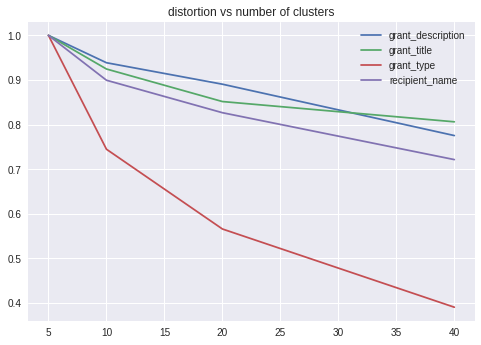

In [35]:
import matplotlib.pyplot as plt
import itertools

def unnest(nested):
  return [item for items in nested for item in items]

distortion_df = pd.DataFrame(km_distortions,index=unnest([[n]*n_repetitions for n in n_clusters]))
distortion_sums = distortion_df.groupby(by=distortion_df.index).sum()
distortion_sums_normalized = distortion_sums/distortion_sums.transpose()[5]
distortion_sums_normalized.plot(title='distortion vs number of clusters')
plt.plot()

Grant description and recipient name had elbows at 10 clusters, while grant title and grant type had elbows at 20 clusters. I clustered over the entire dataset, using these parameters. (All columns finish in 5 minutes or less except grant description, which takes about an hour.)

In [37]:
n_clusters = {'grant_description':10, 'recipient_name':10, 'grant_title':20, 'grant_type':20}
km_models = {c:KMeans(n_clusters=n_clusters[c]) for c in theme_cols}

for c,model in km_models.iteritems():
  print 'computing for '+c+'...'
  %time model.fit(tfidf_matrices[c])
  theme_df[c+'_cluster_number'] = model.labels_.tolist()
  theme_df.to_csv('theme_df.csv')
  print ''

computing for grant_title...
CPU times: user 5min 32s, sys: 56 ms, total: 5min 32s
Wall time: 5min 32s


/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  import sys



computing for grant_type...
CPU times: user 10.9 s, sys: 10 ms, total: 10.9 s
Wall time: 10.9 s

computing for grant_description...
CPU times: user 1h 42s, sys: 278 ms, total: 1h 42s
Wall time: 1h 43s

computing for recipient_name...
CPU times: user 1min 32s, sys: 22 ms, total: 1min 32s
Wall time: 1min 32s



Then, I inspected the clusters for key words, in order to assign semantic labelings to the clusters.

In [0]:
from collections import Counter
def common_words(column,cluster_number):
  booleans = (theme_df.[column+'_cluster_number']==cluster_number)
  clustersize = booleans.sum()
  sample = theme_df[booleans].sample(n=min(1000),clustersize)
  wordcounts = pd.Series(Counter(sample[column+'_tokens'].sum()))
  wordfreqs = wordcounts/wordcounts.sum()
  wordfreqs = wordfreqs[wordfreqs>0.05].sort_values(ascending=False).apply(lambda x: np.round(x,2))
  word_freq = [s.split() for s in str(wordfreqs).split('\n')][:-1]
  return ', '.join([pair[0]+' ('+pair[1]+')' for pair in word_freq])

def example(column,cluster_number):
  booleans = (theme_df.[column+'_cluster_number']==cluster_number)
  all_examples = theme_df[booleans][column].unique()
  return str(random.choice(all_examples))

def readout(column):
  for n in range(n_clusters[column]):
    booleans = (theme_df.[column+'_cluster_number']==n)
    clustersize = booleans.sum()
    print 'Cluster'+str(n)+' (size '+str(clustersize)+')'
    print 'Keywords | '+common_words(column,n)
    for _ in range(5):
      print '   '+example(column,n)
    print ''

In [0]:
# funder --> grant type
# https://datavizcatalogue.com/
# https://plot.ly/~alishobeiri/1591/plotly-sankey-diagrams/#/
grant_type_counts = df.grant_type.value_counts()
grant_types = grant_type_counts[grant_type_counts >= 10]
grant_types_filter = list(grant_types.index)

grant_filter = ((df.grant_award >= 10000) | df.grant_type.apply(lambda x: x in grant_types_filter))
df_grant_filter = df[grant_filter]
viz_df = df_grant_filter.groupby(['funder_name','grant_type']).sum()['grant_award'].reset_index()

In [0]:
funder_rankings = viz_df[['funder_name','grant_award']].groupby('funder_name').sum().sort_values('grant_award',ascending=False).reset_index().funder_name
type_rankings = viz_df[['grant_type','grant_award']].groupby('grant_type').sum().sort_values('grant_award',ascending=False).reset_index().grant_type
type_rankings.index += len(funder_rankings)
rankings = funder_rankings.append(type_rankings)

def nodenum(s):
  return list(rankings.index[rankings==s])[0]

import numpy as np
viz_df['Source']=viz_df.funder_name.apply(nodenum)
viz_df['Target'] = viz_df.grant_type.apply(nodenum)
viz_df['Color']='#262C46'
viz_df['Value']=viz_df['grant_award']#.apply(np.log10)

In [39]:
# https://plot.ly/~alishobeiri/1591/plotly-sankey-diagrams/#/
import plotly.plotly as py
#py.sign_in('jpskycak','I6xndrZUDqf8sWKGmCIL')

data_trace = dict(
    type='sankey',
    domain = dict(
      x =  [0,1],
      y =  [0,1]
    ),
    orientation = "h",
    valueformat = ".0f",
    node = dict(
      pad = 10,
      thickness = 30,
      line = dict(
        color = "black",
        width = 0.5
      ),
      label =  list(rankings),
      color = viz_df['Color']
    ),
    link = dict(
      source = viz_df['Source'],#.dropna(axis=0, how='any'),
      target = viz_df['Target'],#.dropna(axis=0, how='any'),
      value = viz_df['Value']#.dropna(axis=0, how='any'),
  )
)

layout =  dict(
    title = "Grants over $10,000\n(for Grant Types Having 10+ Grants)",
    height = 2000,
    width = 950,
    font = dict(
      size = 10
    ),    
)


fig = dict(data=[data_trace], layout=layout)
py.iplot(fig, validate=False)

In [42]:
# todo: condense grant types into fewer categories, map recipients to industry
#viz_df.grant_type.value_counts()
len(grant_type_counts)

1045

In [43]:
df=df[['funder_name','recipient_name','grant_award','grant_type','grant_title','grant_description']]

,grant_type,recipient_location_lowlevel,recipient_location_highlevel,recipient_region,grant_request,recipient_name,recipient_ward,funder_name,grant_duration_months,grant_description,grant_award,recipient_charity_number,grant_award_date,grant_title,recipient_zip,recipient_district,funder_zip,recipient_country,recipient_company_number
0,Small Grants,Spelthorne,Spelthorne,South East Coast,NaN,Desborough Sailing Club,Shepperton Town Ward,Sport England,3.0,Funding under Sport England's Small Grants fun...,9686.0,NaN,2009-09-14T00:00:00+00:00,Members Boat Scheme,TW17 9LQ,Spelthorne District,NaN,GB,05099435
1,Small Grants,South Lakeland,Westmorland and Lonsdale,North West,NaN,The Brewery,Kendal Highgate Ward,Sport England,4.0,Funding under Sport England's Small Grants fun...,7480.0,1086789,2009-09-14T00:00:00+00:00,Boyz Sport Moves,LA9 4HE,South Lakeland District,NaN,GB,03927101
2,Small Grants,North Hertfordshire,North East Hertfordshire,East of England,NaN,Richard's Trampoline Club,Barton-le-Clay Ward,Sport England,12.0,Funding under Sport England's Small Grants fun...,7690.0,NaN,2009-09-14T00:00:00+00:00,"Growth, Sustain and Excel",MK45 4NF,Central Bedfordshire,NaN,GB,NaN
3,Small Grants,Chichester,Chichester,South East Coast,NaN,Chichester & Fishbourne Croquet Club,Fishbourne Ward,Sport England,1.0,Funding under Sport England's Small Grants fun...,6118.0,NaN,2009-09-14T00:00:00+00:00,New Lawn Mower,PO18 8BL,Chichester District,NaN,GB,NaN
4,Small Grants,Sedgemoor,Wells,South West,NaN,Berrow Short Mat Bowls Club,Berrow Ward,Sport England,12.0,Funding under Sport England's Small Grants fun...,1600.0,NaN,2009-09-14T00:00:00+00:00,Purchase of Bowls Mats,TA8 2QU,Sedgemoor District,NaN,GB,NaN


In [45]:
strayer_df=df[['funder_name','recipient_name','grant_award','grant_type','grant_title','grant_description']]

283077